In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [2]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os
import numpy as np
from utils import get_map
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
from sentinelhub import CRS, BBox, bbox_to_dimensions
from utils import evalscript_true_color, evalscript_ndvi, evalscript_ndwi
from utils import center_crop
from config import IMAGE_SIZE
from utils import to_grayscale
import cv2
from utils import generated_lsm_mask
from PIL import Image
import config
import numpy as np
from torch.utils.data import DataLoader
from dataset import Image_dataset
from generator_model import Generator
from torch import optim
import torch
from config import DEVICE

gen = Generator(in_channels=1, inter_images=4, out_channels=1)
checkpoint = torch.load("model/gen_LSM_v1.pth.tar", map_location=torch.device(DEVICE))
gen.load_state_dict(checkpoint['state_dict'])
optimizer = optim.Adam(gen.parameters())
optimizer.load_state_dict(checkpoint['optimizer'])

config_sentinel = SHConfig(sh_client_id=os.environ.get("sh_client_id"), sh_client_secret=os.environ.get("sh_client_secret"))
config_sentinel.sh_client_id

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
  data = fetch_version_info()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using im

torch.Size([5, 128, 100, 100])


/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_8470/4051600854.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model/gen_LSM_v1.pth

'65f2b211-b283-42d5-9ac6-d3ecf4be5a45'

In [18]:

cords = (83.6076,27.9246,83.6177,27.9321)

resolution = 0.8
bbox = BBox(bbox=cords, crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 0.8 m resolution: (1221, 1066) pixels


In [27]:
maps = get_map(cords, start_date="2021-06-12", end_date="2023-06-13", 
        evalscript_ndvi=evalscript_ndvi, 
        evalscript_true_color=evalscript_true_color, 
        evalscript_ndwi=evalscript_ndwi)

In [ ]:
# gray_image, NDVI, Slope, Elevation, NDWI

In [28]:
new_shape = (IMAGE_SIZE, IMAGE_SIZE)

gray_image = cv2.resize(to_grayscale(maps[0]), (new_shape[0], new_shape[1]))
NDVI = cv2.resize(maps[1], (new_shape[0], new_shape[1]))
Slope = cv2.resize(maps[2], (new_shape[0], new_shape[1]))
Elevation = cv2.resize(maps[3], (new_shape[0], new_shape[1]))
NDWI = cv2.resize(maps[4], (new_shape[0], new_shape[1]))

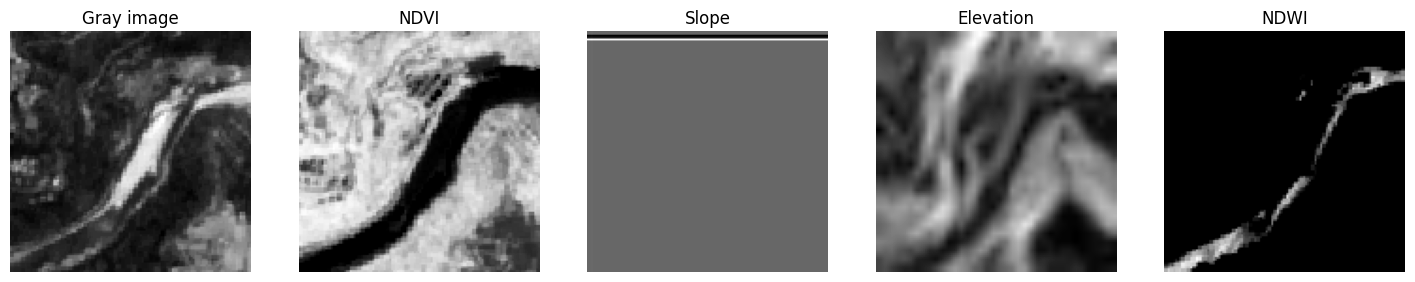

In [29]:
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(18,6))

ax1.set_title("Gray image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("NDWI")

ax1.imshow(gray_image, cmap="gray")
ax2.imshow(NDVI, cmap="gray")
ax3.imshow(Slope, cmap="gray")
ax4.imshow(Elevation, cmap="gray")
ax5.imshow(NDWI, cmap="gray")

ax1.axis("off"); ax2.axis("off"), ax3.axis("off"); ax4.axis("off"), ax5.axis("off")
plt.show()


In [30]:
gray_image_n = cv2.normalize(gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
NDVI_n = cv2.normalize(NDVI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
Slope_n = cv2.normalize(Slope, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
Elevation_n = cv2.normalize(Elevation, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
NDWI_n = cv2.normalize(NDWI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

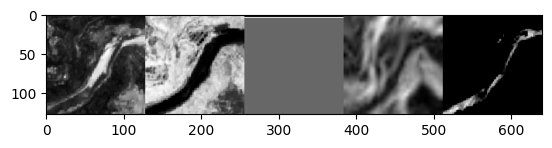

In [31]:
canvas = np.ones((128, 128*5))
canvas[:, 0:128] = gray_image_n
canvas[:, 128:128*2] = NDVI_n
canvas[:, 128*2:128*3] = Slope_n
canvas[:, 128*3:128*4] = Elevation_n
canvas[:, 128*4:128*5] = NDWI_n

plt.imshow(canvas, cmap="gray")

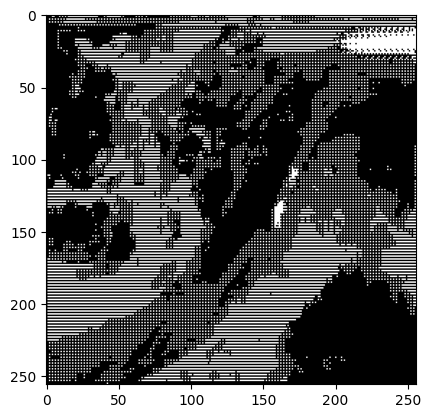

In [32]:
pred = generated_lsm_mask(gen, canvas, already_grayscale=True)
plt.imshow(pred, cmap="gray")